In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import re

# Load price data (daily closing prices from Mar 2021 – Feb 2025)
price_df = pd.read_csv("/snp500_stocks_closing_price_daily_data.csv")

# Load filtered financial data (static from 2021)
financial_df = pd.read_csv("/filtered_security_data.csv")

# Load ESG scores
esg_2022 = pd.read_csv("/esg_scores_2022.csv")
esg_2023 = pd.read_csv("/esg_scores_2023.csv")
esg_2024 = pd.read_csv("/esg_scores_2024.csv")

# Dictionary to handle yearly data
esg_dict = {
    2022: esg_2022,
    2023: esg_2023,
    2024: esg_2024
}

# Extract price columns
price_columns = [col for col in price_df.columns if re.match(r"\d{1,2}-[A-Za-z]{3}-\d{2}", col)]

# Transpose price data for forward return calculation
price_data = price_df.set_index("symbol")[price_columns].T
price_data.index = pd.to_datetime(price_data.index, format="%d-%b-%y")

# Function to compute 1-year forward returns
def get_forward_returns(start_year):
    start_date = pd.Timestamp(f"{start_year}-03-01")
    end_date = pd.Timestamp(f"{start_year+1}-02-28")
    try:
        start_prices = price_data.loc[start_date]
        end_prices = price_data.loc[end_date]
    except KeyError:
        return None  # Year range not available
    return ((end_prices - start_prices) / start_prices).dropna()

# Dictionary to store merged and labeled datasets
yearly_data = {}

for year, esg_df in esg_dict.items():
    forward_returns = get_forward_returns(year)
    if forward_returns is None:
        continue

    merged = pd.merge(esg_df, financial_df, on="symbol", how="inner")
    merged = merged[merged['symbol'].isin(forward_returns.index)]
    merged = merged.dropna(axis=1, how="all")

    # Drop non-numeric columns
    text_columns = ['symbol', 'esgPerformance', 'peerGroup', 'longBusinessSummary']
    numeric_data = merged.drop(columns=[col for col in text_columns if col in merged.columns], errors='ignore')
    numeric_data = numeric_data.select_dtypes(include=['int64', 'float64'])

    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numeric_data.fillna(numeric_data.mean()))
    features_df = pd.DataFrame(scaled_features, columns=numeric_data.columns)
    features_df["symbol"] = merged["symbol"].values
    features_df["target"] = features_df["symbol"].map(forward_returns)

    # Final clean
    features_df = features_df.dropna(subset=["target"])
    yearly_data[year] = features_df.reset_index(drop=True)

print("✅ Prepared yearly data for: ", list(yearly_data.keys()))


✅ Prepared yearly data for:  [2022, 2023, 2024]


In [3]:
!pip install torch torchvision --quiet

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00


In [4]:
class StockDataset(Dataset):
    def __init__(self, features, targets):
        self.x = torch.tensor(features.values, dtype=torch.float32)
        self.y = torch.tensor(targets.values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [8]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Check and clean input data
def clean_data(X, y):
    if X.isnull().values.any() or np.isinf(X.values).any():
        print("Warning: Found NaNs or Infs in X_train. Replacing them with 0.")
        X = X.fillna(0).replace([np.inf, -np.inf], 0)

    if y.isnull().values.any() or np.isinf(y.values).any():
        print("Warning: Found NaNs or Infs in y_train. Replacing them with 0.")
        y = y.fillna(0).replace([np.inf, -np.inf], 0)

    return X, y

X_train, y_train = clean_data(X_train, y_train)

# Define dataset and loader
train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define model
model = MLP(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop with error handling
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    try:
        for xb, yb in train_loader:
            if torch.isnan(xb).any() or torch.isinf(xb).any():
                print("Warning: NaN or Inf in input batch. Skipping this batch.")
                continue
            if torch.isnan(yb).any() or torch.isinf(yb).any():
                print("Warning: NaN or Inf in target batch. Skipping this batch.")
                continue

            pred = model(xb)
            loss = loss_fn(pred, yb)

            if torch.isnan(loss) or torch.isinf(loss):
                print("Warning: Loss is NaN or Inf. Skipping this batch.")
                continue

            optimizer.zero_grad()
            loss.backward()

            # Optional: Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss:.4f}")

    except Exception as e:
        print(f"Exception during training at epoch {epoch}: {str(e)}")


Epoch 0: Loss = 2.0711
Epoch 1: Loss = 2.0364
Epoch 2: Loss = 1.8829
Epoch 3: Loss = 1.8193
Epoch 4: Loss = 1.7500
Epoch 5: Loss = 1.7511
Epoch 6: Loss = 1.7310
Epoch 7: Loss = 1.6696
Epoch 8: Loss = 1.7328
Epoch 9: Loss = 1.7258
Epoch 10: Loss = 1.8604
Epoch 11: Loss = 1.6994
Epoch 12: Loss = 1.5631
Epoch 13: Loss = 1.6829
Epoch 14: Loss = 1.5692
Epoch 15: Loss = 1.5366
Epoch 16: Loss = 1.6349
Epoch 17: Loss = 1.4633
Epoch 18: Loss = 1.5655
Epoch 19: Loss = 1.5060
Epoch 20: Loss = 1.4730
Epoch 21: Loss = 1.4544
Epoch 22: Loss = 1.4026
Epoch 23: Loss = 1.4286
Epoch 24: Loss = 1.4538
Epoch 25: Loss = 1.4251
Epoch 26: Loss = 1.5548
Epoch 27: Loss = 1.4411
Epoch 28: Loss = 1.4632
Epoch 29: Loss = 1.4093
Epoch 30: Loss = 1.4321
Epoch 31: Loss = 1.4049
Epoch 32: Loss = 1.4014
Epoch 33: Loss = 1.3785
Epoch 34: Loss = 1.3196
Epoch 35: Loss = 1.2869
Epoch 36: Loss = 1.3380
Epoch 37: Loss = 1.3610
Epoch 38: Loss = 1.3001
Epoch 39: Loss = 1.3672
Epoch 40: Loss = 1.4518
Epoch 41: Loss = 1.3764
Ep

In [9]:
# Predict on 2024 data
test_df = yearly_data[2024].copy()
X_test = test_df.drop(columns=["symbol", "target"])
symbols = test_df["symbol"]

model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_test.values, dtype=torch.float32)).flatten().numpy()

test_df["predicted_return"] = preds
top20 = test_df.sort_values("predicted_return", ascending=False).head(20)

print("🏆 Top 20 Stocks for 2024:")
print(top20[["symbol", "predicted_return"]])


🏆 Top 20 Stocks for 2024:
    symbol  predicted_return
70    CBOE          0.380680
338    NOW          0.365768
151    FRT          0.306873
25     AMT          0.292718
310    PSA          0.291840
330    RCL          0.280686
292   PAYX          0.277656
63    CDNS          0.271342
175    GWW          0.258906
138   EQIX          0.252725
326    ROK          0.251603
156    FLS          0.236763
45     AVB          0.228353
58     BSX          0.228206
115   DXCM          0.215143
416    ZBH          0.210601
184    HLT          0.200967
88     CFG          0.192635
103    CCI          0.190666
315    PWR          0.189847


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


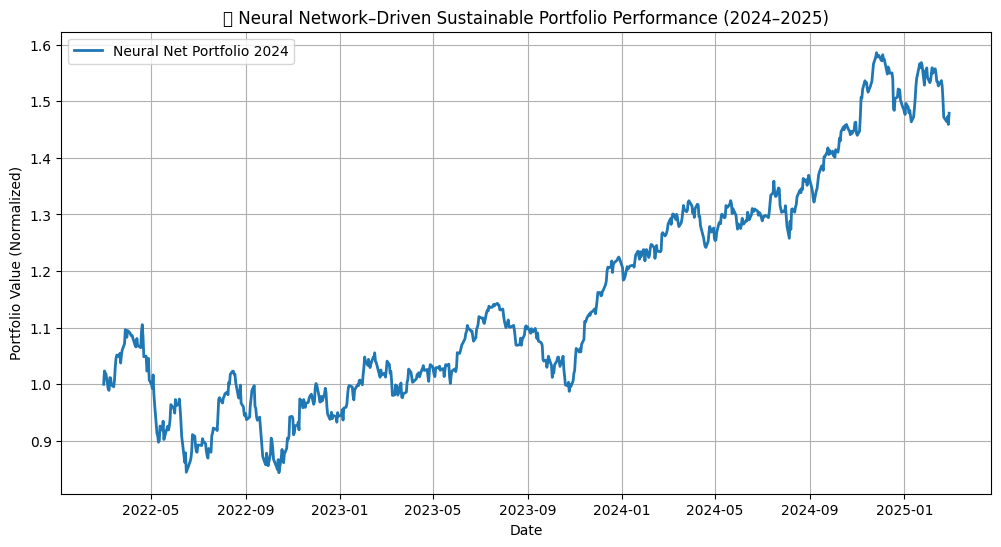

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load daily price data
price_df = pd.read_csv("/snp500_stocks_closing_price_daily_data.csv")
price_df.set_index("symbol", inplace=True)

# Transpose price matrix
price_matrix = price_df.T
price_matrix.index = pd.to_datetime(price_matrix.index, format="%d-%b-%y")
price_matrix = price_matrix.sort_index()  # ✅ Important: sort index for date slicing
price_matrix.columns.name = None

# Select price data for the top 20 symbols and date range
top_symbols = top20["symbol"].values
start_date = "2022-03-01"
end_date = "2025-02-28"
price_subset = price_matrix.loc[start_date:end_date, top_symbols]

# Ensure no missing values (forward and backward fill)
price_subset = price_subset.ffill().bfill()

# Calculate normalized prices (start from 1)
normalized = price_subset / price_subset.iloc[0]

# Equal-weighted portfolio return (optional: use predicted_return-based weights)
weights = np.repeat(1 / len(top_symbols), len(top_symbols))
portfolio_returns = (normalized * weights).sum(axis=1)

# Plot cumulative portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns, label="Neural Net Portfolio 2024", linewidth=2)
plt.title("📈 Neural Network–Driven Sustainable Portfolio Performance (2024–2025)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Normalized)")
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


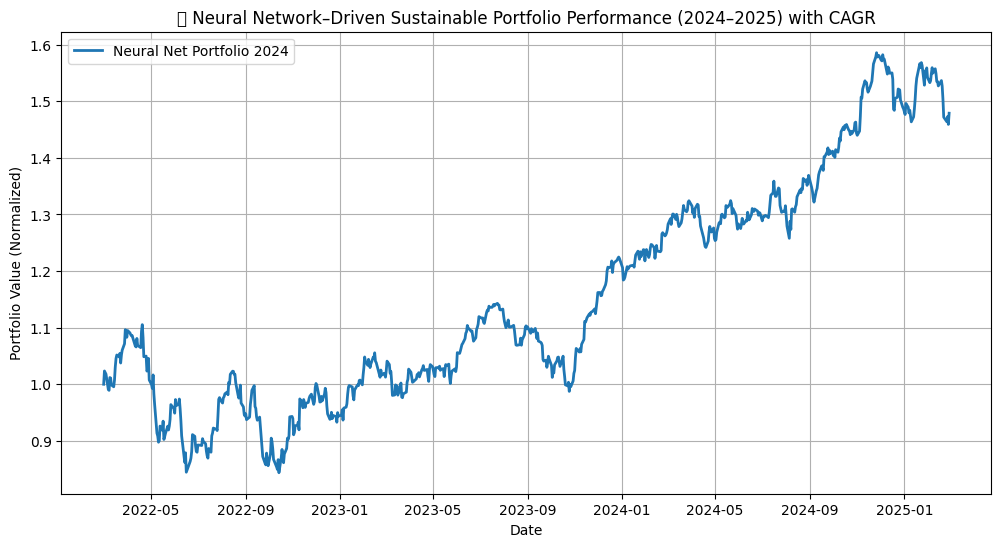

CAGR of the portfolio: 13.94%


In [41]:
# Calculate CAGR (Compound Annual Growth Rate)
initial_value = portfolio_returns.iloc[0]
final_value = portfolio_returns.iloc[-1]
years = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days / 365.25  # Convert days to years
cagr = (final_value / initial_value) ** (1 / years) - 1

# Plot portfolio returns and CAGR
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns, label="Neural Net Portfolio 2024", linewidth=2)
# plt.axhline(y=initial_value * (1 + cagr), color='red', linestyle='--', label=f"CAGR: {cagr:.2%}")
plt.title("📈 Neural Network–Driven Sustainable Portfolio Performance (2024–2025) with CAGR")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Normalized)")
plt.grid(True)
plt.legend()
plt.show()

# Output CAGR for reference
print(f"CAGR of the portfolio: {cagr:.2%}")


<ipython-input-40-4d53612ea879>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], errors='coerce')
<ipython-input-40-4d53612ea879>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data_filtered['daily_return'] = sp500_data_filtered['Close Price'].pct_change().fillna(0)
<ipython-input-40-4d53612ea879>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

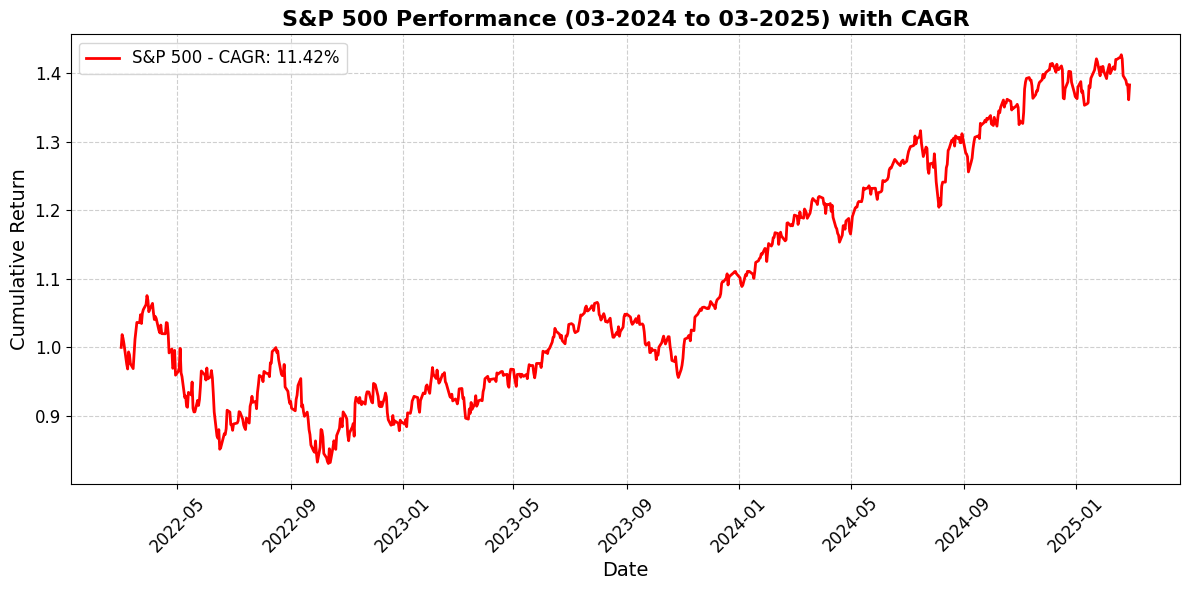

S&P 500 CAGR (03-2023 to 03-2025): 11.42%


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sp500_cagr(sp500_csv_path="/snp500_INDEX_daily_closing_prices.csv"):
    # Load S&P 500 index data
    sp500_data = pd.read_csv(sp500_csv_path)

    # Ensure the 'Date' column is correctly parsed and set as the index
    sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], errors='coerce')

    # Drop any rows where Date could not be parsed correctly
    sp500_data = sp500_data.dropna(subset=['Date'])

    # Set Date as index and sort it to avoid non-monotonic issues
    sp500_data.set_index('Date', inplace=True)
    sp500_data.sort_index(inplace=True)

    # Filter data for the date range from March 2024 to March 2025
    sp500_data_filtered = sp500_data.loc['2022-03-01':'2025-03-01']

    # Check if the filter is successful
    if sp500_data_filtered.empty:
        print("No data found in the specified date range.")
        return None

    # Calculate daily returns and cumulative returns
    sp500_data_filtered['daily_return'] = sp500_data_filtered['Close Price'].pct_change().fillna(0)
    sp500_data_filtered['cumulative_sp500'] = (1 + sp500_data_filtered['daily_return']).cumprod()

    # Calculate CAGR
    start_value = sp500_data_filtered['cumulative_sp500'].iloc[0]
    end_value = sp500_data_filtered['cumulative_sp500'].iloc[-1]
    num_years = (sp500_data_filtered.index[-1] - sp500_data_filtered.index[0]).days / 365.25
    sp500_cagr = (end_value / start_value) ** (1 / num_years) - 1

    # Plot S&P 500 cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(sp500_data_filtered.index, sp500_data_filtered['cumulative_sp500'], label=f"S&P 500 - CAGR: {sp500_cagr:.2%}", color='red', linewidth=2)

    plt.title(f"S&P 500 Performance (03-2024 to 03-2025) with CAGR", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Cumulative Return", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return sp500_cagr

# Call the function to plot
sp500_cagr_value = plot_sp500_cagr()
if sp500_cagr_value is not None:
    print(f"S&P 500 CAGR (03-2023 to 03-2025): {sp500_cagr_value:.2%}")
